# Image Captioning

####  Generating captions for images

###  Steps
##### • Data collection
##### • Understanding the data
##### • Data Cleaning
##### • Loading the training set
##### • Data Preprocessing — Images
##### • Data Preprocessing — Captions
##### • Data Preparation using Generator Function
##### • Word Embeddings
##### • Model Architecture
##### • Inference

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import nltk
from nltk.corpus import stopwords
import re
import string
import json
from time import time
import pickle
import cv2
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
def readTextFile (path):
    with open (path) as f:
        captions = f.read()
        return captions

##### The below file contains 5 caption id's  and 5 captions per image 
###### Goal is to read all the lines of the file

In [3]:
captions=readTextFile("Flickr_TextData/Flickr8k.token.txt")

###### Since the data is so large and we can't print it, therefore we are splitting the data about new line

In [4]:
captions=captions.split("\n")[:-1]

In [5]:
len(captions)

40460

In [6]:
#captions[0]

In [7]:
#first, second=captions[0].split("\t")

In [8]:
#first

In [9]:
#first.split(".")[0]

###### Now we will create a dictionary and map each image with the list of the captions it has
###### Lets name the dictionary as descriptions

In [10]:
descriptions={}
#iterate over every element in the caption
for x in captions:
    first, second= x.split("\t")
    img_name=first.split(".")[0]
      
     # if the image id is present or not   
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    
    descriptions[img_name].append(second)

In [11]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

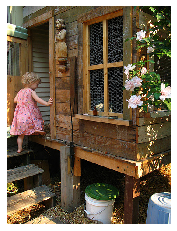

In [12]:
IMG_PATH = "Images/"
img = cv2.imread(IMG_PATH +"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data Cleaning

In [13]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " " ,sentence)      #substitute everything that is not b/w(^)  a to z 
                             #one or more occurance of the preceeding character(+) and replace with space " "
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]  # remove all the words which have a length of 1 
    sentence = " ".join(sentence)
    
    return sentence 

In [14]:
clean_text(" w Finally The Rock has c d come back to ! # 64 india......")

'finally the rock has come back to india'

##### Let's now clean all the captions

In [15]:
for key,caption_list in descriptions.items():
    for i in range (len(caption_list)):
        caption_list[i]= clean_text(caption_list[i])
        

In [16]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

#####  notice the difference  what it is now ( ↑ ) and what it was before ( ↓ )

In [17]:
#['A child in a pink dress is climbing up a set of stairs in an entry way .',
# 'A girl going into a wooden building .',
#'A little girl climbing into a wooden playhouse .',
#'A little girl climbing the stairs to her playhouse .',
#'A little girl in a pink dress going into a wooden cabin .']

####  Now we will write the data in a text file
###### to avoid doing the same work again if in case we need it in the future

In [18]:
with open("descriptions_1.txt","w") as f:   # this file is going to store dictionary in the form of a string 
    f.write(str(descriptions))                                       

#### Before creating Vocubulary
###### We have to open our file that contains all the desctiptions (descriptions_1.txt)
###### Earlier it was a dictionary and we stored that into a file and now it is a string because we are going to read the file and to convert the file back to python dictionary we are using a method json.loads() 

In [19]:
descriptions=None
with open ("descriptions_1.txt", "r") as f:
    descriptions=f.read()
        
json_acceptable_string = descriptions.replace("'","\"") # before the format becomes json acceptable we need 
                                                        # to replace all '' with "\""  in the file
    
descriptions=json.loads(json_acceptable_string)   # this is what converts the string to dictionary                                              
                                                           

In [20]:
type(descriptions)

dict

##### Total number of words across all sentences ↓

In [21]:
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
("Total_words %d" % len(total_words))    
    

'Total_words 373837'

###### des = list of captions , descriptions[key] is a list , i   is a particular word in that caption 
###### desctiption[key] = list containing (caption 0, caption1 ... caption 5)  and des.split() is going to assume every word in thatparticular caption 
###### basically we are iterating over all the captions for a particular key then we go to the next key we see all the captions and all the words and add the words to the total words

#### Now we will create our vocab
###### For that we are using ...    set( ) →  stores all unique words

In [22]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]    # square brakets are imp as we are 
                                                                            # using list comprehension
    

###### For every sentence mapped with the [key] which gives us the caption and that caption is our sentence and we are going to split that sentence into a list of words and pass that list to our vocab function 

In [23]:
("vocab size: %d" % len(vocab))      # these are our unique words 

'vocab size: 8424'

#### Now we are going to remove the words that have frequency less than a particular threshold 

In [24]:
import collections

counter = collections.Counter(total_words) # the counter is going to give us the frequeny count of each word
freq_cnt= dict(counter)

#print(freq_count[0])  
                       # here we have got a dictionary which shows how many time a word occurs for every word


##### We will now sort this dictionary according to the frequency count 

In [25]:
sorted_freq_cnt= sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])
                         

######  ↑  we have to give sorted_freq_cnt.items() not sortesorted_freq_cnt because  sorted function operates on a list not a dictionary
                         
###### WHAT LAMBDA  DOES : since we now have key value pairs eg.child with a frequency value of 72 ("child": 72),and pink with a frequency value of 39 ("pink": 39)  [("pink":39)] this value is "x"  and 39 is x(1) so we are saying that for making the comparision treat the key as x(1) basically do the comparision on the basis of values

#### Applying the filter

In [26]:
threshold = 10 
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]   
                           
total_words = [x[0] for x in sorted_freq_cnt]


In [27]:
print( len(total_words))

1845


###### So 1845 is the final vocab size (total_words) or the unique words. We started with 373837 words, by removing duplicates we got 8424 words and by removing words having less frequency we got 1845 unique words

#### Now we will prepare Train/Test data
###### For all our images we have a common folder which contains all images from 1 to whatever number and we are given a text file which says eg. (1, 4, 5,8.. ) should go into the training of the model and it says eg. image id's (2, 3, 25...) should go into the testing file. Now what we are going to make a file which maps traininig image id's with the captions. We have descriptions which is for all the data, we need to create train descriptions which contain the id's which are present in the training file. For test descriptions it is not needed because test is what we are going to test upon (so we can do a comprasion b/w the generated description and the given description )

In [28]:
train_file_data = readTextFile("Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Flickr_TextData/Flickr_8k.testImages.txt")

In [29]:
#print(train_file_data)      # print this so as to get the idea of why we are doing this ↓

In [30]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

###### Same step as we did in  descriptions in the begining ↑

In [31]:
print(train[:5])                     #  train is the image id   

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']


#### Prepare descriptions for the training data
##### Add "startseq" ( start sequence ) and "endseq" ( end sequence ) to our training data 
###### from these two tokens our model will recocnize, from where the sentence should start and where the sentence should end, and this way also the model will not start with any random word like "running the dog is"

In [32]:
train_descriptions={}

for img_id in train:                     # train is the list of image id's
    train_descriptions[img_id] = []      # this now is a new dictionary, img_id is going to be equal to a list
    for cap in descriptions[img_id]:     # descriptions is the original dictionary, and train_descriptions is a subset of the original descriptions
        cap_to_append = "startseq " + cap + " endseq"    #the caption that we will add to aur training file will have a start sequence + the ooriginal caption + we wil have an ending sequnce 
        train_descriptions[img_id].append(cap_to_append)
        

In [33]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

#### Transfer Learning
##### We will use Transfer Learning to extract features for images

###### Given lot of images we need to extract the features that are relevant for our model
###### we are going to use a pre-trained model to extract features and the model we will use is  ResNet-50 model which is already trained on imageNet (it has 50 layers, and also has skip connection which means our gradients can backpropogate easily, they don't suffer from vanishing gradient problem

##### Instead of taking the entire model we are going to use the convolutional base 
###### we are not going to train this model and use it as feature extrator

Below  ↓  model- ResNet is initialised with imagenet weights and an imput shape of 224,224,3 (because we are having colured images and will have 3 channels)

BELOW WE CAN NOTICE, There is one more column "connected to "  meaning i/p layer is connected to which layers? This column is there because ResNet is a functional model and has skip connections as well (the input is used for more than one o/p ) skip connection basically alows deep networks to learn without facing the issue of vanishing gradient 
#model, there is a branching and to which layers this layer is connected 

In [34]:
model = ResNet50(weights = "imagenet", input_shape=(224, 224, 3))
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [35]:
model.layers[-2].output

<tf.Tensor 'avg_pool/Mean:0' shape=(None, 2048) dtype=float32>

###### model.layers[-2]  is the global avg pooling layer and whatever is the output , that will come from this layer 

In [36]:
model_new = Model(model.input,model.layers[-2].output)

###### This model is a part of keras functional API  in which we need to specicfy the input (whatever is the input that is comming to this new model should go into model.input and this model.input corresponds to the input layer of the ResNet and similarly the output of the new model should come from model.layers[-2] 

##### Now let's try to extract the features for all the images and save them in a file 
###### First step is to preprocess the image before we feed it to a particular model 
###### We are going to feed some images to the ResNet50 model [ model_new , which is Resnet50 conv base ] so we are going to read some image and preprocess that image the way ResNet50 expects it to be and we are going to get a feature vector ( if we feed m images we wil get m x 2048 images in the output) which we will store on the disk, because we don't want to compute the feature vectors again and again 

##### Basically we are going to have two models one is our image captioning model (it needs to get the image feature vector, which we wil compute only once by passing all the images through ResNet )↓

###### Let's extract image feature vectors for all the images 

###### We need to preprocess all the images (preprocess_img)(img) we get in some image 

In [37]:
def preprocess_img(img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)  # convert the image into an array 
    img = np.expand_dims(img, axis=0) 
    
    
# FOR NORMALIZATON  different networks have different ways of normalizing data and there is one method in 
#ResNet50 preprocess_input so we are going to use this method because resnet50 has been trained in using 
# this kind of preprocessing
    img = preprocess_input(img)    # whatever be the preprocessing it will be done by the input 
    return img

    

 img = np.expand_dims(img, axis=0)   # when we load an image it has a shape of 224*224*3 but when we feed this image to ResNet50 we can't feed in single image we have to feed in a batch so the shape should be 
(batch size*224*224*3) which means it should be a 4D Tensor so to convert 3D into 4D so we specify that we are going to expand the dimensions along axis [0] , so by default t wil make it as 1 and now the the shape wil be 1*224*224*3   WE CAN ALSO DO A RESHAPE 
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


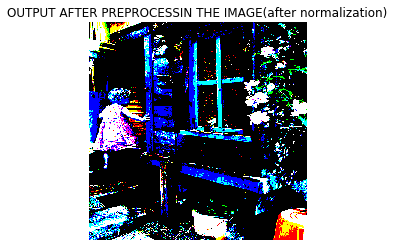

In [38]:
# PREPROCESSING DEMO ....     FOR 1 IMAGE
img = preprocess_img(IMG_PATH +"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.title('OUTPUT AFTER PREPROCESSIN THE IMAGE(after normalization)')
plt.axis("off")
plt.show()

In [39]:
def encode_img(img):
    img = preprocess_img(img) 
    feature_vector = model_new.predict(img)
    #print(feature_vector.shape)
    feature_vector = feature_vector.reshape(-1,)
    #print(feature_vector.shape)
    return feature_vector
    

2\n it calls the preprocess_img method  ↑↑  and it accepts the image, then we are going to feed this preprocessed img to the resnet model , so encode_img is going to follow all the steps so, first you do the  preprocessing next we pass it through the ResNet and whatever encoding we get we will save that 
3\n feature_vector will be given by our new model and we do the precicting on a particular img 
and then we can reshape our feature_vector
    

In [40]:
encode_img(IMG_PATH +"1000268201_693b08cb0e.jpg")

array([0.041543  , 0.17076081, 0.292786  , ..., 0.05089618, 0.3132235 ,
       0.8600756 ], dtype=float32)

###### so basically from 2 axis we are converting output back to a single axis
###### (1, 2048) original shape
###### (2048,)  this is what the shape is now 
###### array([0.041543  , 0.17076081, 0.292786  , ..., 0.05089618, 0.3132235 ,
       0.8600756 ], dtype=float32)    these are the values corresponding to that feature 


### Next step is to encode all images 
###### we have already written a function (encode_img) to encode one image , so we just need to iterate over all the images in the training and test set and encode and save them in one file because the ecnoding is a one time process and is a time consuming function so we are going to store the op in a pickle file 

###### The dictionary encoding_train{} is going to map each img_id with the feature vector, so we will have a corresponding feature vector extracted from ResNet50 and will be stored in this dictionary 
###### so we will iterate over the training set and whatever is the img_id we are enumerating over the training set (train is the list )
###### encoding_train for img_id =  

#### We can also print the progress , 
###### Everytime we complete 100 images 

In [41]:
start_t= time()
encoding_train = {}
for ix, img_id in enumerate(train):    # 
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print ("Encoding in progress time step %d"%ix)
        
end_t = time()
print ("Total time taken :", end_t - start_t)

Encoding in progress time step 0
Encoding in progress time step 100
Encoding in progress time step 200
Encoding in progress time step 300
Encoding in progress time step 400
Encoding in progress time step 500
Encoding in progress time step 600
Encoding in progress time step 700
Encoding in progress time step 800
Encoding in progress time step 900
Encoding in progress time step 1000
Encoding in progress time step 1100
Encoding in progress time step 1200
Encoding in progress time step 1300
Encoding in progress time step 1400
Encoding in progress time step 1500
Encoding in progress time step 1600
Encoding in progress time step 1700
Encoding in progress time step 1800
Encoding in progress time step 1900
Encoding in progress time step 2000
Encoding in progress time step 2100
Encoding in progress time step 2200
Encoding in progress time step 2300
Encoding in progress time step 2400
Encoding in progress time step 2500
Encoding in progress time step 2600
Encoding in progress time step 2700
Enco

#### Now we will store everything on the Disk 
###### For that we need to create a file 
##### Since it is a dictionary and it contains lot of data so we are going to dump the data to our disk , and for that we use PICKLE we  write the data on to the disk and whenever we require this data again we are going to load this file and it will create an object in the RAM ( PICKLE gives us two functions one is pickle.dump and the other is load function ) 

#### We are saving the Encoded Train data in [ encoded_train_features.pkl ] .. file 

In [42]:
#with open ("encoded_train_features.pkl", "wb") as f:
    #pickle.dump(encoding_train,f)   # what we need to dump = encoding_train and second (f) is the file
                                    #pointer wher we need to dump the file 

###    Encoding for the Test data

In [43]:
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]  #this step we have already performed 
                                                                        # in the beginning but still ...

In [44]:
start_t = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path) 
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start_t)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 424.66331791877747


##### We are saving the Encoded Test  data in the [ encoded_test_feature.pkl ] .. file 

In [45]:
#with open ("encoded_test_features.pkl", "wb") as f:
    #pickle.dump(encoding_test,f)   

##  Now, Data Preprocessing for the captions   [ 2nd part  ↓] 
###### Images we have done ↑

When we are going to feed data to our model, every word is a feature and that feature should be represented using a number and to do that we will make a dictionary 
###### we are going to iterate over all the words that we shortlisted for our VOCAB  ( total_words ) to make a dictionary 

In [46]:
len(total_words)              # total_words is just a list 

1845

In [47]:
word_to_index = {}              # given the word what is the corresponding number 
index_to_word = {}             # given the indes what is the corresponding word
for i,word in enumerate (total_words):
    word_to_index[word] = i+1 
    index_to_word[i+1] = word

i+1 , because we want to reserve the index , we are not going to use the dictionary index 0  because, each sentence can have a diffferent length when there is no word eg.(The dog is ...) when there is no word we put a zero there we are going to reserve the 0th index for this purpose and for all other words we will say like The is the 12th word in the dictionary so the will be replaced by 13  DOG is 56th word  is is 104th and so on and if we make this vocab we will be MAP EVERY WORD WITH A NUMBR 
We are going to feed these numbers to our model, let's say we have a caption gererator model it takes numbers and it also predicts numbers because when we take a softmax it is going to give us a number so we need this dictionary index_2_word so if it says the word is 13 so we should be able to say this word is DOG  and initially we need to feed word_2_index, if we want to feed the word Dog we will feed the index 13 

In [48]:
word_to_index['dog']

6

In [49]:
index_to_word[6]

'dog'

#####  We need to add 2 special words that were there in the dictionary 
###### In our data set we don't have the words start seq and the end seq , so we need to add these words manually  to our data set 

In [50]:
len(index_to_word)

1845

In [51]:
index_to_word[1846] =  "startseq"
word_to_index["startseq"] = 1846

In [52]:
index_to_word[1847] =  "endseq"
word_to_index["endseq"] = 1847

In [53]:
 vocab_size = len(word_to_index)+1   # we are having something for index 0 so effictive length will be +1

Below is our final vocab size which inclues the start and end sequence 

In [54]:
print("Vocab size  = ", vocab_size)

Vocab size  =  1848


##### During our training we are not going to feed in a single sentence at a time, but a mini-batch which means at any point during our training we wil have an array of captions which can be of variable length.
We need to find the maximum length in the batch or the maximum len sentence in the dataset, so that wil determine our batch size(max length can be included in two ways either we can make it fixed for entire training process, let's say our largest sentence will have 40 words and if we find 1 or 2 sentences larger than it we can clip that othe option is that we can take the maximum of sentence in a particular batch, so we can have variable no of columns while generating the data, but for now we are going to make it fixed for the entire training set 
 so we will find the largest length of the caption 

In [55]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))  # max length of whatever is the max now and the length of 
                                                # the current caption which is len(cap.split)

In [56]:
print(max_len)

35


### Data Loader (Generator)

##### In the first step we will define a data_genrator method , which would be a generator function which is going to accept train_descriptions, which is a dictionary which maps image id with the captions for the training data , we also have encoding train which gives us how a particular image is mapped with the 2048 dimensional vector, we also have word_to_index (how to convert a given word into index) we also have the max_len which gives us the maximum length of any sentence in the entire dataset and finally the batch_size , how many images we want to feed in a batch (how many training examples we want to have in a particular batch.

#####  we also know our data has two things , in the x-array which is a matrix we will have images and we will have partial captions, so we are going to build these partial captions and we are going to have the corresponding images 

##### we don't know X1, X2, y so we are initialising them with empty list 
###### so we can iterate over key  value pairs so, key is our image id and we have caption list (desc_list) in train_descriptions.items

######   photo = encoding_train[key+".jpg"]     there is a photo which is encoding of train basically the image path (image id) with single image we have multiple captions so we will iterate over all the captions 

######    for desc in desc_list :
###### we can pick out one particular sequence and convert it into a list of numbers so our sequence wil be word to index of word for word in descriptions.split if word in  word_to_index (if mapping is not present we are going to ignore that word  , for unknown words we are going to ignore it )
 
######    xi = pad_sequence([]) we will pad xi using the pad_sequence function available in keras and it accepts 2d matrix so we convert xi into 2d matrix this way → [xi]  and value with which we should pad = 0 (because we have reserved 0 for padding word)  for pading  and padding =  "post" means we are adding the padding after the sequence of numbers. [0] means we need to get the 0th element 
[xi] acepts a 2d list and returns a 2d matrix , and since we have only one example so we need to access the 0th element by doing [0]

##### yi is a number (since we know whenn we are making a neural network we need to convert our numbers in the output as oneHot values 
##### when we get xi and yi we basically get 1 training point  so we wiil append these in the batch

#####  yield  we are not using return function it is a generator and generator remembers the state where the function was in the previous call so we will convert x into an array { X1 np.array(X1),np.array(X2) } are combined as a single feature and make y an array as well 

In [57]:
def data_generator (train_descriptions, encoding_train,word_to_index,max_len, batch_size):
    X1, X2, y = [],[],[]
    
    n=0  #how many items we have in our batch 
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1   # we are going to read one particular image  
            
            photo = encoding_train[key+".jpg"]    
            for desc in desc_list :
                seq = [word_to_index[word] for word in desc.split() if word in word_to_index]
                for i in range (1, len(seq)): # this would be a list (1 to length of sequence )
                    xi = seq [0:i]   # input xi ( we will slice the seq fro 0 to ith index )
                    yi = seq[i]       # our prediction yi wil be equal to seq of i 
                    
                    
                    xi = pad_sequence([xi], maxlen=max_len, value=0,padding= 'post')[0]
                    yi = to_categorical ([yi], num_classes=vocab_size)[0]   # we wil access the 0 element @@@
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield[[np.array(X1),np.array(X2),np.array(y)]]
                    
     # for the next function call when the control comes back to the generator function again 
                    
                    X1, X2, y = [],[],[]         # empty list again because we don't want to add examples 
                                                 # that were already there 
                    n=0
                    
                    
                    
                

 photo = encoding_train[key+".jpg"]     lets say image is abc.jpg  and we have multiple captions (cap1 cap2 cap3 cap4) so we pick cap1 (Dog is running ) and then convert all the words into numbers 
 (13, 42, 58, 77endseq) → and from this lis we will generate multiple training points in which the image will remain same (abc.jpg) 
 so we will be slicing from 0 to first index  which means we will slice from 0 to 13 (0 to i) i = 13 next time we wil have 0 to i (i is basically going to iterate over (13, 42, 58, 77endseq)  and we will have 13and42 and in this case given 13 our preciction should be 42....  and then 13, 42,58 .. ( given 13, 14 aur pred should be 58) and so on ..   and later on we have to do padding so that every xi is of same length  

## Word Embeddings

Now we are going to see how we can convert our numbers that we have for our given words into something meaningful, for that we are going to use the concept of transfer learning and we would be using glove embeddings to convert our caption word indices into glove embeddings 
We used transfer learning for the images and now we wil use it for text 
If we have a RNN layer or LHTM layer : whenever we feed some data into it that data must pass through Embedding layer, we can train this embedding layer as we move or we can pre-initialize this layer (for that in our case we are going to use glove vectors ) and we are going to use the file glove.gB.50d.text, it contains glove embedding of 6 billion words and each is a 50 dimensional vector but in our case we don't need all 6 billion words, we just need the words which are there in our vocab.
We can make a matrix vocab size * 50  (for each word in the vocab we have a 50 dimensional vector which is available in the matrix )   WE NEED TO CONSTRUCT THIS MATRIX
 So, we will construct a matrix from already trained glove vector 

In [58]:
import numpy as np

In [59]:
f = open ("glove.6B.50d.txt", encoding="utf8")

In [60]:
embedding_index = {}

for line in f:       # iterate over every line in the file 
    values = line.split()  #when we split the word, in the file the first element is the word and  next 50 are the embeddings  """
                             
    
    word = values[0]          # our word is the vlaues of [0] index 
    word_embedding = np.array(values[1:], dtype="float")        #everything else is a numpy array, which is from index 1 to last """
                                                                      
    embedding_index[word] = word_embedding
                                          # embedding of index of given word = word_embedding"""
    
    
    

In [61]:
f.close()

#### We are done with reading the above file since there are 6 billion words in the file but we do not need to keep all the words we need to keep only those words which are there in our vocab, and it is also possible that there is some word "abc" which is there in vocab but not there in the glove vector in that case we will initialize that row as the row of all zeros.

In [62]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

### Now let's build the embedding matrix 

###### we know embedding dimension is going to be 50 because each word can be represented as a 50 dimensional vector 
######  matrix = np.zeros((vocab_size, emb_dim))  So our matrix is going to be a matrix of zeros which has vocab size and embedding size 

######  embedding_vector = embedding_index.get(word)  # we pick some word that is in vocab and we ask our embedding index which is a dictionary created from the glove embeddings and we check if that particular word is present in it or not 

In [63]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word, index in word_to_index.items():   """.items gives us the key and the value, word_to_index is a 
                                                a dictionary that maps every word with the index """ 
        
    embedding_vector = embedding_index.get(word) #we pick a word in vocab and ask embedding_index 
                                                         #dictionary whether that word is present or not
        
    if embedding_vector is not None:
             matrix[index] = embedding_vector # matrix index is going to be equql to embedding_vector
                
    return matrix    

 So, what we are doing above is, let's say we found a word "the" which is there in the vocab so we are just reading all the vocab [an, the, rock, car, . . . . . ]  say we have a word "car" in there so we check in the dictionary what is the glove vector of "car" and let's say car is mapped with the 5th index , so then in the 5th index in the matrix which, corresponds to car we put a vector there [...........]  each word is represented using a 50 dimensional vector. Whenever we pass a car through the embedding matrix we get we get the row containing 50 numbers which correspond to the car 

If the word is null then the row will contain all zeros
       

In [64]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [65]:
#embedding_matrix[1847]       # it is going to be all zeros because startsequence is not there in glove_embed

## Model Architecture 

First part is to convert our feature vector of images into a smaller vector, so we wil have an image feature vector (input_img_feaure) that will go into the Input layer whose size is 2048 in other words the output of the ResNet will go into this input layer, and we have already stored that output of the ResNet in a file and from that file we are just reading those features and feeding to our model so those features will be directly fed into this input layer

inp_img1 = whatever is the input received, we can apply dropout and drop some of the features randomly (Dropout is a layer where we specify what should go as input (input_img_features) 

inp_img2 = here we are converting our 2048 dimensional vector into a 256 dimensional vector and activation is Relu and the output from the previous layer (inp_img1) goes in as the input to this layer 

In [66]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation = "relu")(inp_img1)

### We also need to have one more model wher we will accept captions as Input 
To read the captions we will have input_captions  that again will be an Input layer whose shape is going to be max_len  (in reality we are going to give batch size *  max length as input but whenever we take input we specify for one sample , and batch size we can have of any length)

The output from the first layer in this model inp_cap1  will come from an Embedding layer which has input dimensions as vocab size and output dimensions as 50 because glove embedding does this work , there is a matrix of vocab size 50 which we will initialize later on ) and there is a parameter mask equal to True and we feed in some input here (input_captions)

Embeddings are ready then we can add some dropout and pass it to some LSTM 

The final layer LSTM ( whatever is the input apply a layer of LSTM cells ) and input_cap2 wil go in as the input here   256 does not denote the number of cells but it denotes what is the output size . ( here we have input of batch size * 35 which goes through an embedding layer which makes it batch size * 35 * embedding size for each word (50) that goes through a lstm and produces a 256 dimensional vector 

In [67]:
input_captions = Input (shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


### Now we want to add one more component to this model wher we will add the inputs and decode them 

decoder1 is one layer and it is the keras add layer (it basically adds two tesors which are of same dimensions one is our imp_img2 the output that we got from the processed images and the output that we got from processing captions inp_cap3(img_cap3 captures the entire sentence that we have generated till now) [since this is not a sequential model but a complex model that is why we are using the keras functional api to build this model  

******imp_img2 and img_cap3 are combined to get another 256 dimensional vector from the add layer that goes through a dense layer which also has 256 dimensions and then it goes through a dense layer of 256 dim and then it goes through a dense layer whose size is equal to the vocab size 1847 dimensions and then we do a softmax finally we get the probability of the next word this is how the data is flowing in this model****** 

The next layer in our decoder model will be a dense layer 

In [68]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)


### Combined Model 

In [69]:
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [70]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

#### One important thing that we have to do is pre-initialize the Embedding Layer 
embedding layer is at the second index, embedding layer contains one matrix (embedding_matrix) which we have prepared
we are going to initialize this matrix by the weights that we have generated in the embedding matrix and we are going to say do not train these layers 

In [71]:
model.layers[2].set_weights([embedding_matrix]) 
    
model.layers[2].trainable=False  

In [72]:
model.compile(loss="categorical_crossentropy",optimizer="adam")

## Model Training

we will see how we can use the generator that we have done 
we have to specify the number of epochs and the number of photos that we are going to take in a batch 
no. of steps will be total images we want (len(train_descriptions ) // number_pics_per_batch   "from each image we can have multiple data points 

In [73]:
len(train_descriptions)

6000

In [124]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)// 200

First step is to iterate over all the epochs  
we need the generator object, generator instance which is nothing but data_generator, and we give the possible parameters train_descriptions, encoding_train, word_to_index,max_len and we also need to specify the batch size 
and now we will call model.fit_generator because  we don't have training data we have generator instance (keras has this function model.fit_generator which accepts which accepts the generator and it is going to call this generator automatically and everytime we call the generator , it gives us the next batch of data and whatever is the data generated for this particular batch that would be passed for 1 epoch ) it basically means how many times you want that batch to pass through the current epoch, ........ and there is one more parameter steps_per_epoch "from each image we can have multiple data points so we are saying that all of our training data should go throug the model, let's say we have 90 examples in our training data and batch size is 3 which means we are passing 3 examples, so whow many steps it will take to pass all the 90 examples that would be 90 /3 which is 30 steps 

In [158]:
def train ():
    for i in range(epochs):
        generator = data_generator(train_descriptions, encoding_train,word_to_index, max_len, batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epochs=steps, verbose=1)
        model.save("model_weights/model_"+str(i)+".h5")

In [159]:
model = load_model('model_weights/model_9.h5')

## Prediction

In [160]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = index_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

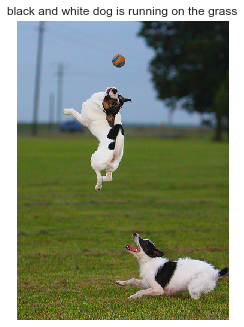

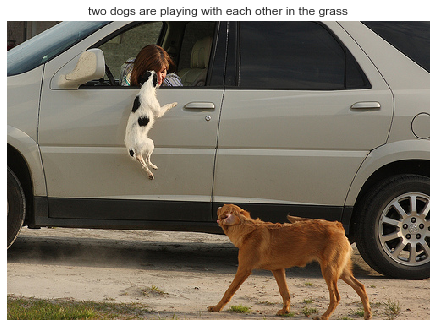

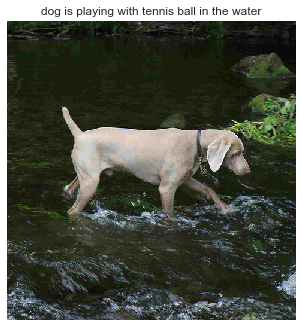

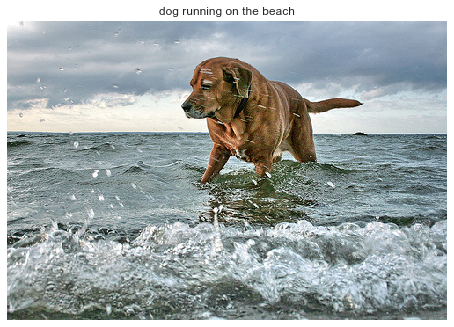

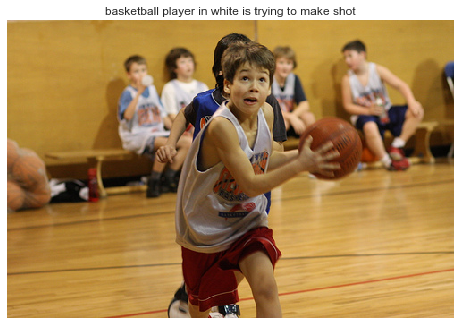

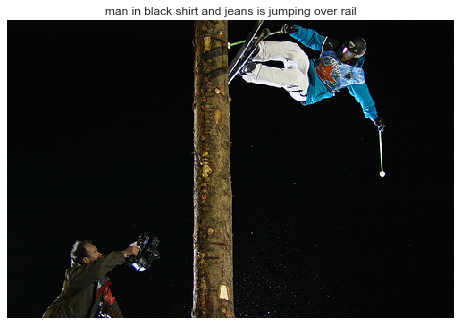

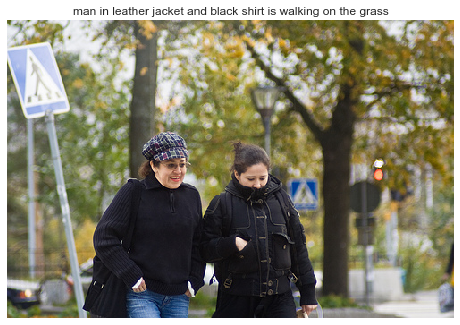

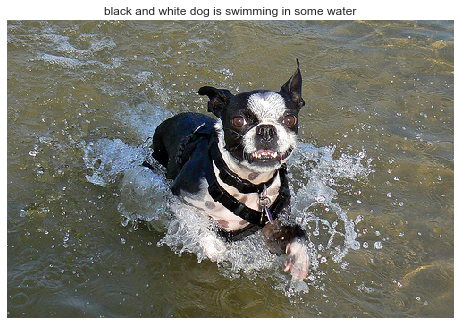

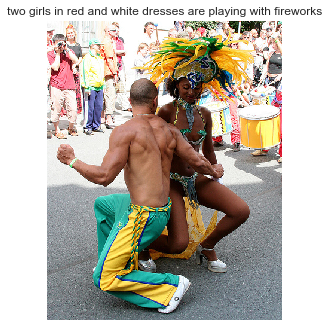

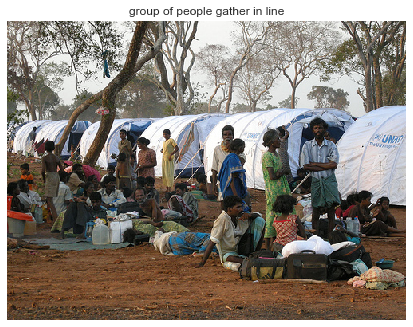

In [165]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(10):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()